In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
#import kerastuner

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from kerastuner.tuners import RandomSearch

In [2]:
batch_size = 32
img_height = 224
img_width = 224
train_dir ="./data/to_train"
test_dir ="./data/to_test"
valid_dir ="./data/to_valid"

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2204 files belonging to 15 classes.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75 files belonging to 15 classes.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75 files belonging to 15 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

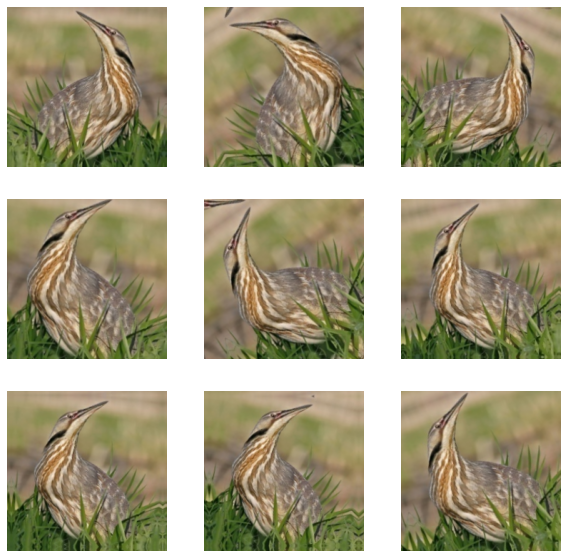

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(500):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
num_classes =15
def build_model(hp):
#     model = Sequential([
#       data_augmentation,
#       layers.experimental.preprocessing.Rescaling(1./255),
#       layers.Conv2D(16, 3, padding='same', activation='relu'),
#       layers.MaxPooling2D(),
#       layers.Conv2D(32, 3, padding='same', activation='relu'),
#       layers.MaxPooling2D(),
#       layers.Conv2D(64, 3, padding='same', activation='relu'),
#       layers.MaxPooling2D(),
#       layers.Dropout(0.2),
#       layers.Flatten(),
#       layers.Dense(128, activation='relu'),
#       layers.Dense(num_classes,activation='softmax')
#     ])
    
#     model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
    
    #rewrite my model
#     model = keras.Sequential()
#     model.add(data_augmentation)
#     model.add(layers.experimental.preprocessing.Rescaling(1./255))
#     model.add(layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D())
#     model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D())
#     model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D())
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(num_classes,activation='softmax'))
    model = keras.Sequential()
    model.add(data_augmentation)
    model.add(layers.experimental.preprocessing.Rescaling(1./255))
    model.add(layers.Conv2D(filters=hp.Int('filters',
                                        min_value=16,
                                        max_value=64,
                                        step=16), kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(filters=hp.Int('filters',
                                        min_value=16,
                                        max_value=64,
                                        step=16), kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(filters=hp.Int('filters',
                                        min_value=16,
                                        max_value=64,
                                        step=16), kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(rate=hp.Float('rate',min_value=0.1,max_value=0.9,step=0.2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes,activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-1, 1e-2, 1e-3])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [12]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='random_search',
    project_name='birds')

INFO:tensorflow:Reloading Oracle from existing project random_search\birds\oracle.json
INFO:tensorflow:Reloading Tuner from random_search\birds\tuner0.json


In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.2, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [16]:
tuner.search(train_ds,
  validation_data=val_ds,
  epochs=5)

Trial 5 Complete [00h 16m 16s]
val_accuracy: 0.06666667014360428

Best val_accuracy So Far: 0.6444444259007772
Total elapsed time: 01h 24m 25s
INFO:tensorflow:Oracle triggered exit


In [14]:
model = tuner.get_best_models(num_models=1)

In [15]:
tuner.results_summary()

Results summary
Results in random_search\birds
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
filters: 32
rate: 0.7000000000000001
learning_rate: 0.001
Score: 0.6444444259007772
Trial summary
Hyperparameters:
filters: 64
rate: 0.30000000000000004
learning_rate: 0.01
Score: 0.06666667014360428
Trial summary
Hyperparameters:
filters: 64
rate: 0.5000000000000001
learning_rate: 0.01
Score: 0.06666667014360428
Trial summary
Hyperparameters:
filters: 32
rate: 0.30000000000000004
learning_rate: 0.1
Score: 0.06666667014360428
Trial summary
Hyperparameters:
filters: 48
rate: 0.30000000000000004
learning_rate: 0.01
Score: 0.06666667014360428


In [16]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [17]:
model =model[0]

In [18]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

3/3 [==============================] - 1s 91ms/step - loss: 1.1325 - accuracy: 0.6693
Accuracy 0.6666666865348816


In [19]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
69/69 [==============================] - 42s 596ms/step - loss: 1.4333 - accuracy: 0.5340 - val_loss: 1.1968 - val_accuracy: 0.6400
Epoch 2/20
69/69 [==============================] - 40s 584ms/step - loss: 1.2997 - accuracy: 0.5926 - val_loss: 1.0564 - val_accuracy: 0.6533
Epoch 3/20
69/69 [==============================] - 40s 581ms/step - loss: 1.2044 - accuracy: 0.6093 - val_loss: 1.0771 - val_accuracy: 0.7200
Epoch 4/20
69/69 [==============================] - 41s 592ms/step - loss: 1.1437 - accuracy: 0.6302 - val_loss: 0.8797 - val_accuracy: 0.7333
Epoch 5/20
69/69 [==============================] - 40s 584ms/step - loss: 1.0874 - accuracy: 0.6397 - val_loss: 0.7763 - val_accuracy: 0.7200
Epoch 6/20
69/69 [==============================] - 40s 581ms/step - loss: 1.0466 - accuracy: 0.6642 - val_loss: 0.8539 - val_accuracy: 0.7600
Epoch 7/20
69/69 [==============================] - 40s 581ms/step - loss: 0.9909 - accuracy: 0.6751 - val_loss: 0.7596 - val_accuracy: 0.7467

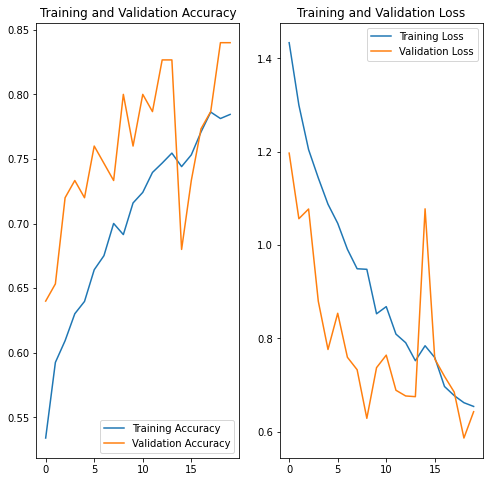

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
loss, acc = model.evaluate(train_ds)
print("Accuracy", acc)

69/69 [==============================] - 10s 138ms/step - loss: 0.4419 - accuracy: 0.8607
Accuracy 0.8607078194618225


In [37]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

3/3 [==============================] - 0s 94ms/step - loss: 0.2209 - accuracy: 0.9333
Accuracy 0.9333333373069763


In [38]:
test_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [39]:
predicted = model.predict(test_ds)

In [40]:
predicted_categories = tf.argmax(predicted, axis=1)

In [41]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)

In [42]:
true_categories

<tf.Tensor: shape=(75,), dtype=int32, numpy=
array([10, 11, 11,  9, 14,  2,  4, 14,  5,  3,  2,  6,  9,  4, 10, 13,  0,
        8, 14,  6,  2,  0,  3,  2,  7,  1,  1, 11,  8,  5,  1,  1,  7,  2,
        0,  4,  7, 13,  4, 10, 12,  6, 14,  7,  6, 11, 13, 12, 12,  5,  3,
        5,  7,  8,  9,  3, 12, 10,  0,  4,  9,  0, 10, 11, 12, 13,  3,  8,
        1,  6,  9, 13,  5,  8, 14])>

In [43]:
predicted_categories

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([10, 11, 11,  9, 14,  2,  4, 14,  5,  3,  6,  6,  5,  4, 10, 13,  0,
        8, 14,  6,  4,  0,  3,  4,  7,  1,  1, 11,  8,  5,  1,  1,  7,  2,
        0, 14,  7, 13,  4, 10, 12,  6, 14,  7,  6, 11, 13, 12, 12,  5,  3,
        5,  7,  8,  9,  3, 12, 10,  0,  4,  9,  0, 10, 11, 12, 13,  3,  8,
        1,  6,  9, 13,  5,  8, 14], dtype=int64)>

In [44]:
from sklearn.metrics import classification_report
print(classification_report(true_categories,predicted_categories))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.40      0.57         5
           3       1.00      1.00      1.00         5
           4       0.67      0.80      0.73         5
           5       0.83      1.00      0.91         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       0.83      1.00      0.91         5

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94   

In [45]:
from sklearn.metrics import confusion_matrix
import pandas as pd
print(pd.DataFrame(confusion_matrix(true_categories, predicted_categories)))

    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
0    5   0   0   0   0   0   0   0   0   0   0   0   0   0   0
1    0   5   0   0   0   0   0   0   0   0   0   0   0   0   0
2    0   0   2   0   2   0   1   0   0   0   0   0   0   0   0
3    0   0   0   5   0   0   0   0   0   0   0   0   0   0   0
4    0   0   0   0   4   0   0   0   0   0   0   0   0   0   1
5    0   0   0   0   0   5   0   0   0   0   0   0   0   0   0
6    0   0   0   0   0   0   5   0   0   0   0   0   0   0   0
7    0   0   0   0   0   0   0   5   0   0   0   0   0   0   0
8    0   0   0   0   0   0   0   0   5   0   0   0   0   0   0
9    0   0   0   0   0   1   0   0   0   4   0   0   0   0   0
10   0   0   0   0   0   0   0   0   0   0   5   0   0   0   0
11   0   0   0   0   0   0   0   0   0   0   0   5   0   0   0
12   0   0   0   0   0   0   0   0   0   0   0   0   5   0   0
13   0   0   0   0   0   0   0   0   0   0   0   0   0   5   0
14   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [46]:
class_names

['AFRICAN CROWNED CRANE',
 'AFRICAN FIREFINCH',
 'ALBATROSS',
 'ALEXANDRINE PARAKEET',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'ANHINGA',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ARARIPE MANAKIN']

In [61]:
predicted_categories_np =predicted_categories.numpy();
true_categories_np=true_categories.numpy();
fail = true_categories_np != predicted_categories_np
print(fail)

[False False False False False False False False False False  True False
  True False False False False False False False  True False False  True
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


In [153]:
fail_indexes =np.where(true_categories_np != predicted_categories_np)[0]

In [8]:
fail_indexes = np.array([10,12,20,23,35])

In [48]:
test_ds[0]

TypeError: 'PrefetchDataset' object is not subscriptable

In [36]:
res =test_ds.take(35)

In [37]:
plt.imshow(res[0])

TypeError: 'TakeDataset' object is not subscriptable

In [42]:
images_list =[];
for index in fail_indexes:
    for images, _ in test_ds.take(index):
        #plt.imshow(images[0].numpy().astype("uint8"))
        images_list.append(images[5].numpy().astype("uint8"))
        break
    

In [43]:
images_list

[array([[[160, 169, 164],
         [141, 147, 143],
         [135, 139, 138],
         ...,
         [ 99,  95,  92],
         [102, 101,  97],
         [ 98,  97,  93]],
 
        [[160, 169, 166],
         [146, 152, 150],
         [146, 150, 149],
         ...,
         [102, 101,  97],
         [108, 107, 103],
         [114, 113, 109]],
 
        [[159, 168, 167],
         [155, 161, 161],
         [166, 168, 167],
         ...,
         [120, 119, 114],
         [127, 126, 122],
         [136, 136, 134]],
 
        ...,
 
        [[167, 168, 170],
         [159, 163, 164],
         [154, 155, 157],
         ...,
         [139, 135, 106],
         [140, 137, 102],
         [131, 129,  91]],
 
        [[166, 168, 180],
         [163, 167, 178],
         [156, 158, 170],
         ...,
         [112, 111,  81],
         [128, 129,  89],
         [134, 135,  91]],
 
        [[167, 170, 187],
         [166, 169, 186],
         [161, 164, 179],
         ...,
         [ 76,  77,  45],
  

0
1
2
3
4


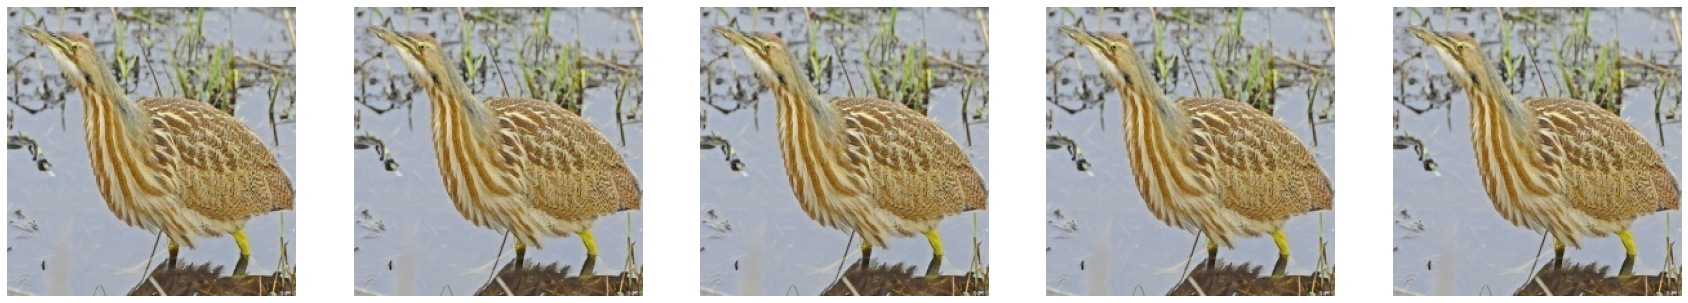

In [44]:
plt.figure(figsize=(30, 30))
for img_index in range(len(images_list)):
    ax = plt.subplot(1, 5, img_index + 1)
    plt.imshow(images_list[img_index])
    plt.axis("off")
    print(img_index)

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(500):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

NameError: name 'data_augmentation' is not defined

<Figure size 720x720 with 0 Axes>